<a href="https://colab.research.google.com/github/rainbow2125514/CS114.K21/blob/master/DoAn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Các thành viên thực hiện:

1.   Nguyễn Võ Hùng Vỹ : 18521683
2.   Nguyễn Thị Hà : 18520691
3.   Nguyễn Hải Ngọc : 18520321

# **FACE MASK DETECTION**

In [ ]:
#thư viện hổ trợ việc xử lý ảnh
import cv2

#thư viện dùng để chiếu ảnh trên colab
from google.colab.patches import cv2_imshow

#thư viện để đọc file csv
import pandas as pd

#các thư viện hổ trợ trong machine learning
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#thư viện vẽ đồ thị số lượng
import seaborn as sns

#thư viện để lưu model
import pickle 

#thư viện dùng để đọc file ảnh bằng url
from skimage import io

#thư viện khi dùng mobilenet_v2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import os


 
1.   crop_img: nhằm resize ảnh về ma trận 150x150
2.   paint_img: dùng cho phần dự đoán, nếu kết quả là ô vuông xanh thì nghĩa là có đeo khẩu trang, đỏ nghĩa là không đeo
3.   saveModel: Lưu model lại
4.   openModel: Load model



In [ ]:
def crop_img(img):
    img_cropped=cv2.resize(img,dsize=(150,150))
    return img_cropped

def paint_img(img,x,y,w,h,is_mask):
    if (is_mask == "with_mask"):
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    else:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),2)
    return img

def saveModel(model,link=None):
    if link == None:
        with open("pickle.txt", "wb") as f:
            pickle.dump(model, f)
    else:
         with open(link + "\pickle.txt", "wb") as f:
            pickle.dump(model, f)
            
def openModel(link=None):
    if link == None:
        with open("pickle.txt", "rb") as f:
            p = pickle.load(f)
    else:
        with open(link + "\pickle.txt", "rb") as f:
            p = pickle.load(f)
    return p

Hàm git clone này dùng để down tập datasets để train (link nằm trong phần tài liệu tham khảo). Cách xử lý datasets và gán nhãn labels nằm ở link sau:https://github.com/rainbow2125514/CS114.K21/blob/master/gannhan.ipynb

In [ ]:
!git clone https://github.com/rainbow2125514/datasets

Cloning into 'datasets'...
remote: Enumerating objects: 812, done.
remote: Counting objects: 100% (812/812), done.
remote: Compressing objects: 100% (811/811), done.
remote: Total 2629 (delta 3), reused 809 (delta 1), pack-reused 1817
Receiving objects: 100% (2629/2629), 84.49 MiB | 35.92 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [ ]:
cd ./datasets

/content/datasets/datasets/datasets/datasets


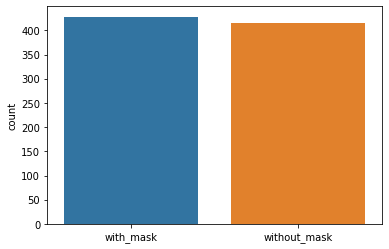

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
dataset=pd.read_csv("data_img.csv").values
datas=dataset[:,0]
targets=dataset[:,1]
sns.countplot(targets)

quá trình xử lý dữ liệu để có thể train

In [ ]:
print(type(dataset))
print(type(datas))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
newdataset=[]
list_target_convert=[]
for i in range(len(datas)):
    img=cv2.imread(datas[i])
    img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img=crop_img(img)
    newdataset.append(img.flatten())
    list_target_convert.append(targets[i])

phần này datasets tách làm 2 phần : train và test

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(newdataset,list_target_convert,train_size=0.8)

Sử dụng model SVC

In [ ]:
model=SVC()
model.fit(x_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
y_predict=model.predict(x_test)
print("Accuracy score :",accuracy_score(y_test, y_predict))


cnf_matrix = confusion_matrix(y_test, y_predict,labels=["with_mask","without_mask"])
print('Confusion matrix:')
print(cnf_matrix)

cnf_matrix_nor = confusion_matrix(y_test, y_predict,labels=["with_mask","without_mask"],normalize='true')
print('Confusion matrix normalize:')
print(cnf_matrix_nor)

print("precision score :",precision_score(y_test, y_predict, average='macro'))
print("recall score :",recall_score(y_test, y_predict, average='macro'))

Accuracy score : 0.9349112426035503
Confusion matrix:
[[71  9]
 [ 2 87]]
Confusion matrix normalize:
[[0.8875     0.1125    ]
 [0.02247191 0.97752809]]
precision score : 0.9394263698630136
recall score : 0.9325140449438202


# Phần dự đoán

### Sử dụng cascade

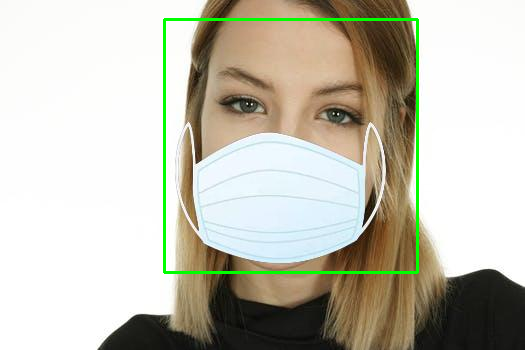

In [ ]:
data_test1=cv2.imread("52.jpg")
data_gray2 = cv2.cvtColor(data_test1, cv2.COLOR_BGR2GRAY)
faces_pred2=face_cascade.detectMultiScale(data_gray2,minSize=(150,150))
if(len(faces_pred2)!=0):
    for (x,y,w,h) in faces_pred2:
        try:
            preded2=crop_img(data_gray2[x:x+w,y:y+h])
            mask_pred2=model.predict(preded2.flatten().reshape(1,-1))
            data_test1=paint_img(data_test1,x,y,w,h,mask_pred2)
        except:
            Exception
cv2_imshow(data_test1)


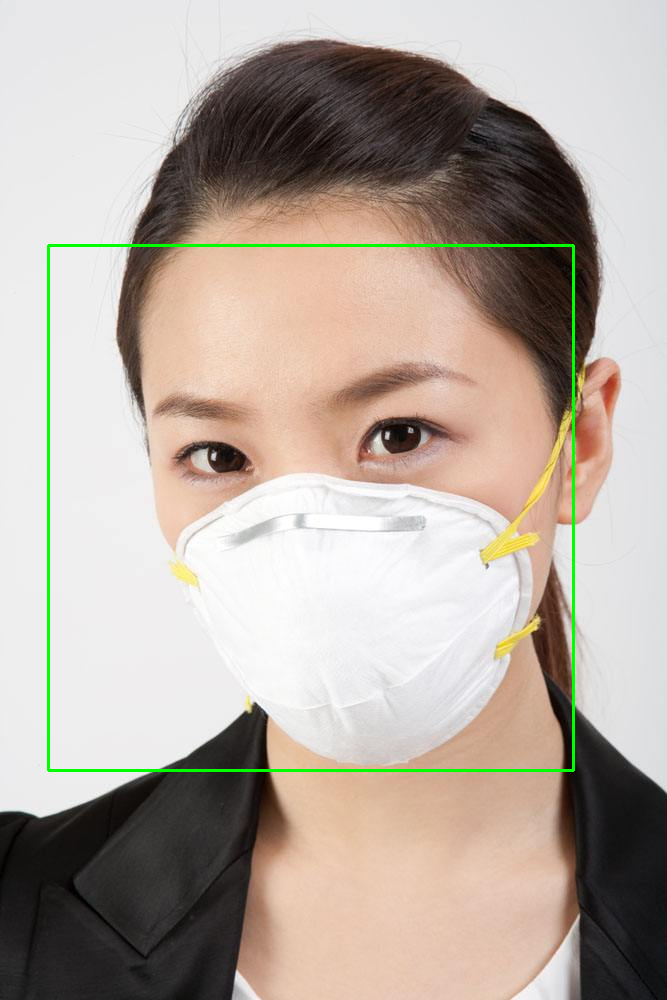

In [ ]:
data_pred2=cv2.imread("predict/2.jpg")
data_gray2 = cv2.cvtColor(data_pred2, cv2.COLOR_BGR2GRAY)
faces_pred2=face_cascade.detectMultiScale(data_gray2,minSize=(150,150))
if(len(faces_pred2)!=0):
    for (x,y,w,h) in faces_pred2:
        try:
            preded2=crop_img(data_gray2[x:x+w,y:y+h])
            mask_pred2=model.predict(preded2.flatten().reshape(1,-1))
            data_pred2=paint_img(data_pred2,x,y,w,h,mask_pred2)
        except:
            Exception
cv2_imshow(data_pred2)


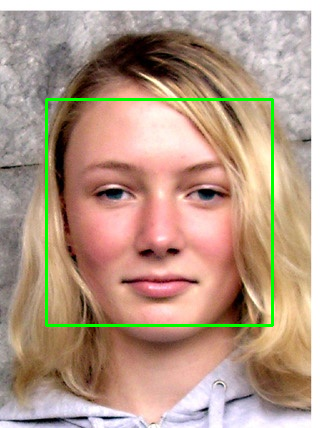

In [ ]:
data_test1=cv2.imread("51.jpg")
data_gray2 = cv2.cvtColor(data_test1, cv2.COLOR_BGR2GRAY)
faces_pred2=face_cascade.detectMultiScale(data_gray2,minSize=(150,150))
if(len(faces_pred2)!=0):
    for (x,y,w,h) in faces_pred2:
        try:
            preded2=crop_img(data_gray2[x:x+w,y:y+h])
            mask_pred2=model.predict(preded2.flatten().reshape(1,-1))
            data_test1=paint_img(data_test1,x,y,w,h,mask_pred2)
        except:
            Exception
cv2_imshow(data_test1)


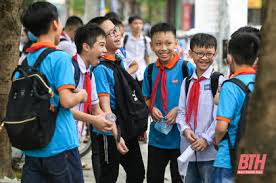

In [ ]:
path="https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ2oDYPrJDNZowkvwlkaFd9usUryyV6sOtSRA&usqp=CAU"
img_url = io.imread(path)
data_pred=cv2.cvtColor(img_url, cv2.COLOR_BGR2RGB)
data_gray = cv2.cvtColor(data_pred, cv2.COLOR_BGR2GRAY)
faces_pred=face_cascade.detectMultiScale(data_gray,minSize=(150,150))
if(len(faces_pred)!=0):
    for (x,y,w,h) in faces_pred:
        try:
            preded=crop_img(data_gray[x:x+w,y:y+h])
            mask_pred=model.predict(preded.flatten().reshape(1,-1))
            data_pred=paint_img(data_pred,x,y,w,h,mask_pred)
        except:
            Exception
cv2_imshow(data_pred)

### Sử dụng mobilenet_v2

[INFO] computing face detections...


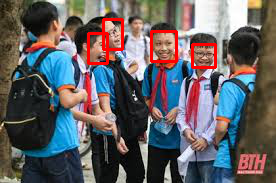

-1

In [ ]:
image_path="https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ2oDYPrJDNZowkvwlkaFd9usUryyV6sOtSRA&usqp=CAU"
image=io.imread(image_path)
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
orig = image.copy()
(h, w) = image.shape[:2]
prototxtPath = os.path.sep.join(["face_detector", "deploy.prototxt"])
weightsPath = os.path.sep.join(["face_detector",
	"res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),(104.0, 177.0, 123.0))
print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward()
for i in range(0, detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence > 0.3:
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
            face = image[startY:endY, startX:endX]
            face=cv2.resize(face,dsize=(150,150))
            face=cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            mask_pred=model.predict(face.flatten().reshape(1,-1))
            image=paint_img(image,startX,startY,endX-startX,endY-startY,mask_pred)
        except:
            Exception
cv2_imshow(image)
cv2.waitKey(0)

## So sánh

[INFO] using cascade face detections.......


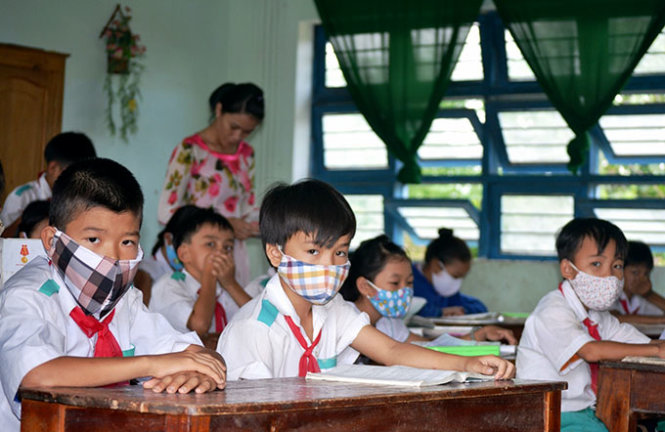

[INFO] using mobilenet_v2 face detections.......


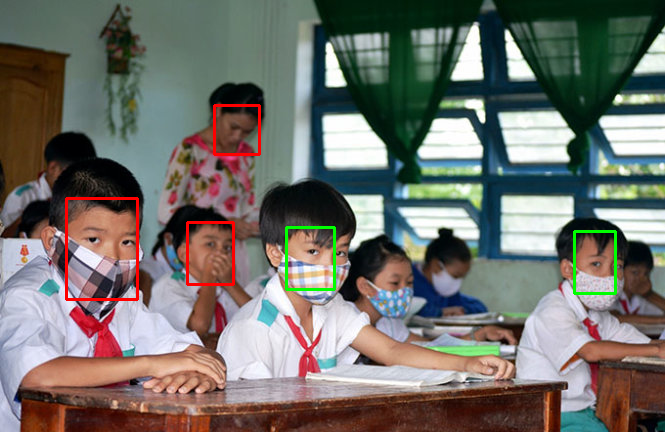

-1

In [ ]:
image_path="https://static.tuoitre.vn/tto/i/s626/2015/04/08/i6m7ygSh.jpg"
img_url = io.imread(image_path)
print("[INFO] using cascade face detections.......")
data_pred=cv2.cvtColor(img_url, cv2.COLOR_BGR2RGB)
data_gray = cv2.cvtColor(data_pred, cv2.COLOR_BGR2GRAY)
faces_pred=face_cascade.detectMultiScale(data_gray,minSize=(150,150))
if(len(faces_pred)!=0):
    for (x,y,w,h) in faces_pred:
        try:
            preded=crop_img(data_gray[x:x+w,y:y+h])
            mask_pred=model.predict(preded.flatten().reshape(1,-1))
            data_pred=paint_img(data_pred,x,y,w,h,mask_pred)
        except:
            Exception
cv2_imshow(data_pred)


image=io.imread(image_path)
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
orig = image.copy()
(h, w) = image.shape[:2]
prototxtPath = os.path.sep.join(["face_detector", "deploy.prototxt"])
weightsPath = os.path.sep.join(["face_detector",
	"res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),(104.0, 177.0, 123.0))
print("[INFO] using mobilenet_v2 face detections.......")
net.setInput(blob)
detections = net.forward()
for i in range(0, detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence > 0.3:
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
            face = image[startY:endY, startX:endX]
            face=cv2.resize(face,dsize=(150,150))
            face=cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            mask_pred=model.predict(face.flatten().reshape(1,-1))
            image=paint_img(image,startX,startY,endX-startX,endY-startY,mask_pred)
        except:
            Exception
cv2_imshow(image)
cv2.waitKey(0)

# Tài liệu tham khảo

https://www.kaggle.com/andrewmvd/face-mask-detection

https://github.com/prajnasb/observations/tree/master/mask_classifier/Data_Generator

https://www.pyimagesearch.com/2015/03/02/convert-url-to-image-with-python-and-opencv/